# Simple Deterministic Agent

The agent has a number multiple thresholds according to - say - the number of infectious cases.

## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np

import virl
import utils

## Simulation

In [3]:
env = virl.Epidemic(stochastic=False, noisy=False)

"""
Args:
    stochastic (bool): Is the infection rate sampled from some distribution at the beginning of each episode (default: False)?
    noisy (bool): Is the state a noisy estimate of the true state (default: False)?
    problem_id (int): Deterministic parameterization of the epidemic (default: 0).
"""

states = []
rewards = []
action_taken = []

# Required to compute the goodness of a policy

discount = 0.9

# We only consider the state of this simulation
env = virl.Epidemic(stochastic=False, noisy=False)
s = env.reset()
s, r, done, i = env.step(action=0)
states.append(s)
rewards.append(r)
action_taken.append(0)

while not done:
    #s, r, done, i = env.step(action=action) # deterministic agent
    susceptible, infectious, quarantined, recovered = states[-1]
    
    infection_rate = infectious / (infectious + susceptible + quarantined + recovered)

    print(infection_rate)
    
    if infection_rate >= 0.01:
        action_id = 1
    elif infection_rate >= 0.005:
        action_id = 2
    elif infection_rate >= 0.001:
        action_id = 3
    else:
        action_id = 0

    s, r, done, i = env.step(action=action_id)
    
    states.append(s)
    rewards.append(r)
    action_taken.append(action_id)

0.00014873001497368738
0.0006629376006444098
0.0029414649554878615
0.005575095228949868
0.007290283563799966
0.009431698334532163
0.012036155463905887
0.004880296232187479
0.008702000986414988
0.01080656625011125
0.004377641151709056
0.0075520777950803435
0.009160209606709435
0.010971888991701186
0.004438911211546972
0.0073098630464017034
0.008559254688001772
0.00990866254552978
0.011322211976166485
0.0045729756337607235
0.007086419392949927
0.007922533334605068
0.008768224058484044
0.009597321855708557
0.010379654853177187
0.004184228933360966
0.006050475711061194
0.0064239431916600495
0.006767424377977822
0.0070713384515559904
0.007326690208278529
0.007525616893699495
0.007661896885808012
0.0077313647482433
0.007732185261745906
0.007664955325567503
0.007532624292822242
0.007340246239345946
0.0070945975228037935
0.006803706346878151
0.006476346192776879
0.006121542126164308
0.005748129910095887
0.005364395195458116
0.004977806552335664
0.005934644099481727
0.00543506162470127
0.004949

In [4]:
print(np.array(states)[:, 1])

[  89238.00898421  397762.56038665 1764878.97329272 3345057.13736992
 4374170.13827997 5659019.00071929 7221693.27834352 2928177.73931248
 5221200.59184898 6483939.75006674 2626584.69102543 4531246.6770482
 5496125.76402565 6583133.39502069 2663346.72692817 4385917.82784101
 5135552.81280104 5945197.52731785 6793327.18569987 2743785.38025642
 4251851.63576994 4753520.00076303 5260934.43509041 5758393.11342512
 6227792.91190629 2510537.36001657 3630285.4266367  3854365.91499602
 4060454.62678668 4242803.07093358 4396014.1249671  4515370.13621968
 4597138.13148479 4638818.84894597 4639311.15704753 4598973.19534049
 4519574.57569333 4404147.74360755 4256758.51368226 4082223.80812687
 3885807.71566611 3672925.27569857 3448877.94605752 3218637.11727486
 2986683.93140139 3560786.45968902 3261036.97482075 2969671.68235548
 3456139.89729972 3107836.88534871 2779914.67684571 3163211.89182546]


In [5]:
print(action_taken)

[0, 0, 0, 3, 2, 2, 2, 1, 3, 2, 1, 3, 2, 2, 1, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3]


## Analysis

total reward -1.1228586575302093


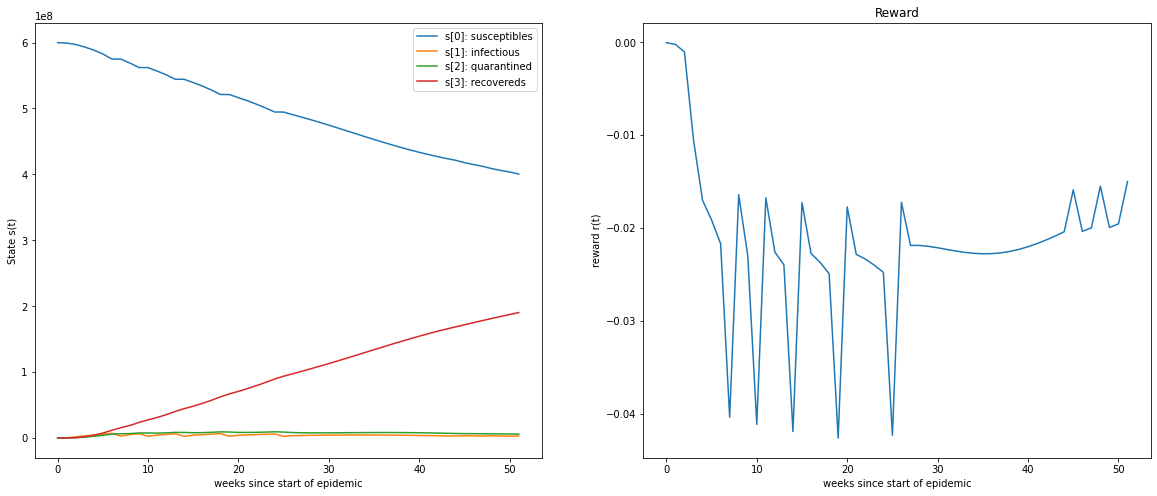

In [6]:
utils.plot(states, rewards)

## Part 2: a greedy deterministic approach

The reward function is simply defined like this:

```python
a = s[1] + s[2]
# s: epidemic state (normalized)
# c: policy severity
b = 1-c
return (-30*a - 30*a**2 - b - b**2)/62
```

where s[1] and s[2] are respectively the infectious and quarantined people, c is the choice (ranging from no restriction (0), full lockdown (1), track & trace (2), social distancing(3)).

We would like to plug in this reward function to perform a greedy choice. Unfortunately, this only works if we could see the next reward. In general, we cannot compute the reward of an action unless and until we perform it, unless we make a clone of the SIQR environment. But this sounds very unrealistic and would defeat the idea of a model-agnostic solution.

Thus, we will simplify the model as follows:



In [62]:
def eval_reward(state, action):
    policy_severity_factor = 1e11
    a = state[1] + state[2]
    b = (1 - action)
    
    expected_a = a*(1 + action - 0.1)
    val = (-expected_a - expected_a ** 2 - policy_severity_factor*b - policy_severity_factor*b**2) / policy_severity_factor
    
    return val

states = []
rewards = []
action_taken = []
expected_reward = []

# Required to compute the goodness of a policy

discount = 0.9

# We only consider the state of this simulation
env = virl.Epidemic(stochastic=False, noisy=False)
s = env.reset()
s, r, done, i = env.step(action=0)
states.append(s)
rewards.append(r)
action_taken.append(0)

while not done:
    #s, r, done, i = env.step(action=action) # deterministic agent
    s = states[-1]
    
    greedy_rewards = np.array([eval_reward(s, a) for a in env.actions])
    print(greedy_rewards)
    action_id = np.argmax(greedy_rewards)
    expected_reward.append(np.max(greedy_rewards))
    
    s, r, done, i = env.step(action=action_id)
    
    states.append(s)
    rewards.append(r)
    action_taken.append(action_id)

[-0.42762681 -2.04752392 -0.98217451 -0.75709128]
[-9.03921659 -4.05563938 -5.65772054 -6.48821274]
[-4.39250955 -2.97208546 -3.13485411 -3.39577085]
[-2.34329765 -2.49423477 -2.02226227 -2.03199453]
[-2.55174175 -2.54284135 -2.13543417 -2.1707167 ]
[-3.181169   -2.68961595 -2.47717318 -2.58960847]
[-4.43789486 -2.98266875 -3.15949545 -3.42597535]
[-2.38274117 -2.50343251 -2.04367759 -2.05824469]
[-2.52256351 -2.53603735 -2.11959224 -2.15129822]
[-3.06477359 -2.66247399 -2.41397787 -2.51214586]
[-4.1870377  -2.924172   -3.02329596 -3.25902676]
[-2.25338571 -2.47326842 -1.97344579 -1.97215699]
[-3.18106698 -2.68959216 -2.47711779 -2.58954058]
[-4.37744542 -2.9685727  -3.12667525 -3.38574549]
[-2.35375054 -2.49667226 -2.02793752 -2.03895105]
[-2.47323866 -2.5245354  -2.09281198 -2.1184719 ]
[-2.9819823  -2.6431681  -2.36902746 -2.45704721]
[-4.04540876 -2.89114589 -2.94640045 -3.16477091]
[-2.17870948 -2.45585486 -1.93290135 -1.92245902]
[-3.05676022 -2.66060537 -2.40962712 -2.50681286]


In [63]:
print(action_taken)

[0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 3, 2, 1, 3, 2, 1, 2, 2, 2, 1, 3, 2, 1, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 1, 2]


total reward -0.880025404543352
total reward -0.880025404543352


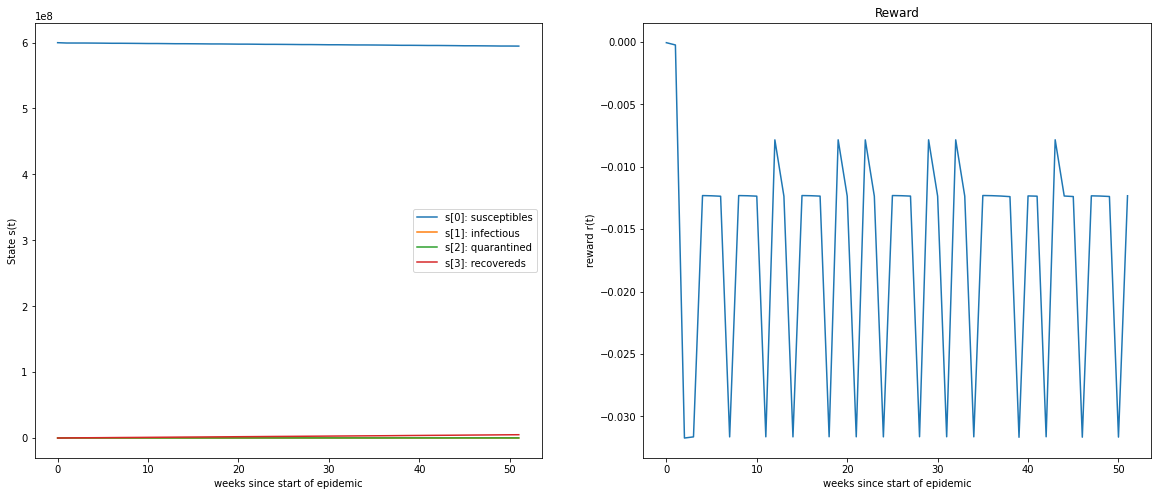

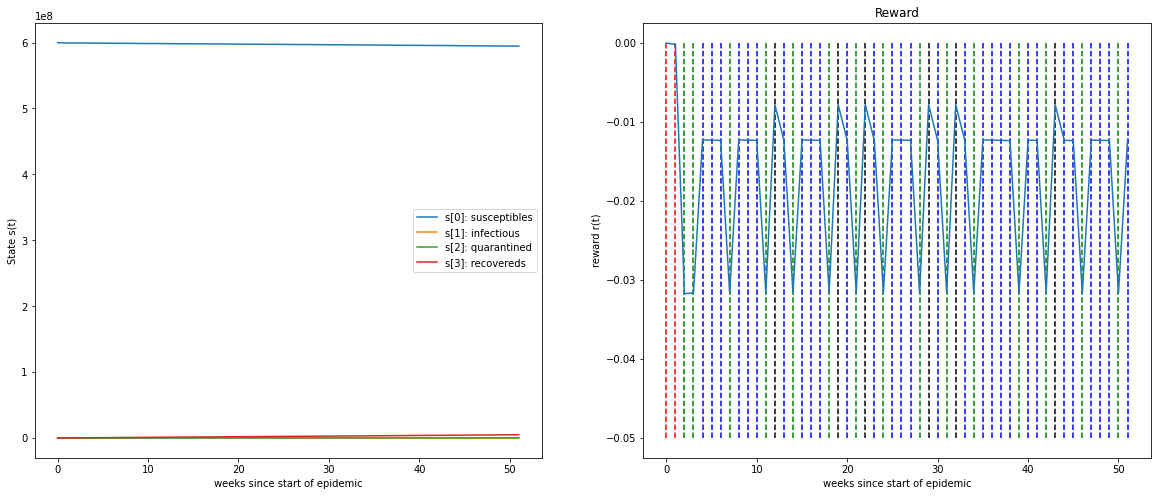

In [70]:
utils.plot(states, rewards)
utils.plot(states, rewards, action_taken)plt.plot([env.actions[action] for action in action_taken])

We now compare our reward estimation function (i.e. our utility function) and the actual reward. We perform some whitening to get a nice, readable plot.

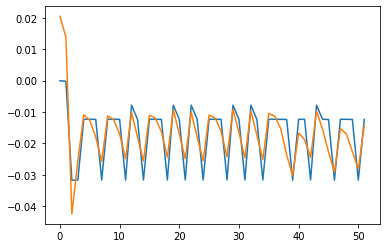

In [55]:
expected_reward_extended = [0] + expected_reward

normalized_expected_reward = (expected_reward_extended - np.mean(expected_reward_extended)) / \
                                np.std(expected_reward_extended) * np.std(rewards) + np.mean(rewards)

plt.plot(rewards)
plt.plot([0] + normalized_expected_reward )

Our deterministic upholds people's safety  